In [1]:
"""
# Advanced Blood Glucose Prediction System
Complete implementation with enhanced feature engineering and modeling
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError
import warnings

warnings.filterwarnings('ignore')

In [2]:
### 1. Data Loading and Preparation

def load_data_files(data_dir):
    """Load all data files from directory"""
    files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) 
             if f.endswith(('.txt', '.csv'))]
    if not files:
        raise ValueError(f"No data files found in {data_dir}")
    print(f"Loaded {len(files)} data files")
    return sorted(files)

def process_raw_data(files):
    """Process and clean raw data files"""
    dfs = []
    for file in files:
        try:
            df = pd.read_csv(file, sep='\t', header=None,
                           names=['date', 'time', 'code', 'value'])
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            df = df.dropna(subset=['value'])
            dfs.append(df)
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
    
    if not dfs:
        raise ValueError("No valid data processed")
    
    combined = pd.concat(dfs, ignore_index=True)
    combined['datetime'] = pd.to_datetime(combined['date'] + ' ' + combined['time'],
                                        dayfirst=True, errors='coerce')
    return combined.dropna(subset=['datetime']).sort_values('datetime')

In [3]:
# 2. REVISED FEATURE ENGINEERING
def create_enhanced_features(df):
    bg_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
    bg_data = df[df['code'].isin(bg_codes)].copy()
    
    # Improved rolling features with larger window
    bg_data['rolling_avg_12h'] = bg_data['value'].rolling(window=6, min_periods=1).mean()
    bg_data['rolling_trend'] = bg_data['value'].diff(3)  # 3-period trend
    
    features = []
    targets = []
    
    for i in range(3, len(bg_data)):  # Start from 3 to have proper trends
        current = bg_data.iloc[i]
        
        # Enhanced time features
        hour = current['datetime'].hour
        time_features = {
            'hour_sin': np.sin(2*np.pi*hour/24),
            'hour_cos': np.cos(2*np.pi*hour/24),
            'is_meal_time': int(hour in [7,12,18]),  # Common meal times
        }
        
        # Recent events with variable windows
        past_6h = df[(df['datetime'] < current['datetime']) & 
                    (df['datetime'] >= current['datetime'] - pd.Timedelta(hours=6))]
        past_12h = df[(df['datetime'] < current['datetime']) & 
                     (df['datetime'] >= current['datetime'] - pd.Timedelta(hours=12))]
        
        # Enhanced treatment features
        treatment_features = {
            'recent_insulin': past_6h[past_6h['code'].isin([33,34,35])]['value'].sum(),
            'total_insulin_12h': past_12h[past_12h['code'].isin([33,34,35])]['value'].sum(),
            'meals_6h': len(past_6h[past_6h['code'].isin([66,67,68])]),
            'exercise_6h': len(past_6h[past_6h['code'].isin([69,70,71])]),
        }
        
        # BG history features
        history_features = {
            'prev_1': bg_data.iloc[i-1]['value'],
            'prev_2': bg_data.iloc[i-2]['value'],
            'prev_3': bg_data.iloc[i-3]['value'],
            'rolling_avg': current['rolling_avg_12h'],
            'trend': current['rolling_trend'],
        }
        
        # Combine all features
        feature = {**time_features, **treatment_features, **history_features}
        features.append(feature)
        targets.append(current['value'])
    
    return pd.DataFrame(features), np.array(targets)

In [4]:
### 3. Data Preprocessing

def preprocess_data(X, y):
    """Prepare data for modeling with robust scaling"""
    # Convert to pandas Series for quantile calculation
    y_series = pd.Series(y.flatten() if isinstance(y, np.ndarray) else y)
    
    # Clip extreme values (1st and 99th percentiles)
    lower_bound = y_series.quantile(0.01)
    upper_bound = y_series.quantile(0.99)
    y_clipped = np.clip(y, lower_bound, upper_bound)
    
    # Scale features - ensure X is 2D
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    scaler_X = RobustScaler(quantile_range=(5, 95))
    X_scaled = scaler_X.fit_transform(X)
    
    # Scale target - ensure y is 2D
    if len(y_clipped.shape) == 1:
        y_clipped = y_clipped.reshape(-1, 1)
    
    scaler_y = RobustScaler(quantile_range=(5, 95))
    y_scaled = scaler_y.fit_transform(y_clipped)
    
    return X_scaled, y_scaled, scaler_X, scaler_y

In [5]:
# 4. REVISED MODEL ARCHITECTURE
def build_advanced_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True,
             kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(32, return_sequences=False,
             kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,  # Increased from 0.0001
        clipvalue=0.5
    )
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', RootMeanSquaredError()]
    )
    return model

In [6]:
# 5. REVISED TRAINING APPROACH
def train_model(model, X_train, y_train, X_val, y_val):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=False  # Important for time series data
    )
    return history

In [7]:
# 5. DATA CHECKS
def verify_data(X, y):
    print("\n=== DATA VERIFICATION ===")
    print(f"Features shape: {X.shape}")
    print(f"Target stats: Min={y.min():.1f}, Max={y.max():.1f}, Mean={y.mean():.1f}")
    print("Feature means:")
    print(pd.DataFrame(X).mean())
    
    # Plot target distribution
    plt.figure(figsize=(10,4))
    plt.hist(y, bins=50)
    plt.title('Target Value Distribution')
    plt.xlabel('Blood Glucose (mg/dL)')
    plt.ylabel('Frequency')
    plt.show()

In [8]:
### 6. Evaluation and Visualization

def evaluate_results(model, X_test, y_test, scaler_y):
    """Generate comprehensive evaluation metrics and plots"""
    # Make predictions
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)
    
    # Calculate errors
    errors = y_true - y_pred
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    
    print("\n=== Model Performance ===")
    print(f"MAE: {mae:.1f} mg/dL")
    print(f"RMSE: {rmse:.1f} mg/dL")
    print(f"Within ±20 mg/dL: {np.mean(np.abs(errors) <= 20)*100:.1f}%")
    print(f"Within ±30 mg/dL: {np.mean(np.abs(errors) <= 30)*100:.1f}%")
    print(f"Within ±50 mg/dL: {np.mean(np.abs(errors) <= 50)*100:.1f}%")
    
    # Prediction plot
    plt.figure(figsize=(15, 6))
    plt.plot(y_true, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--', alpha=0.7)
    plt.fill_between(range(len(y_true)), 
                    y_true.flatten()-20, y_true.flatten()+20,
                    color='blue', alpha=0.1, label='±20 mg/dL error band')
    plt.title('Blood Glucose Predictions vs Actual Values', pad=20)
    plt.ylabel('Blood Glucose (mg/dL)')
    plt.xlabel('Sample Index')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    # Error distribution
    plt.figure(figsize=(15, 5))
    plt.hist(errors, bins=50, color='purple', alpha=0.7)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error (mg/dL)')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    # Scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual BG (mg/dL)')
    plt.ylabel('Predicted BG (mg/dL)')
    plt.title('Actual vs Predicted Blood Glucose')
    plt.grid()
    plt.show()

=== Loading Data ===
Loaded 70 data files

=== Creating Features ===

=== Preprocessing Data ===
X_scaled shape before reshape: (13515, 12)
y_scaled shape: (13515, 1)
X_scaled shape after reshape: (13515, 1, 12)

=== Building Model ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 192 (768.00 B)


=== Training Model ===
Epoch 1/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.5165 - mae: 0.5373 - root_mean_squared_error: 0.7030 - val_loss: 0.1024 - val_mae: 0.2723 - val_root_mean_squared_error: 0.3200 - learning_rate: 0.0010
Epoch 2/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1045 - mae: 0.2550 - root_mean_squared_error: 0.3230 - val_loss: 0.0599 - val_mae: 0.2054 - val_root_mean_squared_error: 0.2453 - learning_rate: 0.0010
Epoch 3/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0668 - mae: 0.2034 - root_mean_squared_error: 0.2582 - val_loss: 0.0256 - val_mae: 0.1281 - val_root_mean_squared_error: 0.1596 - learning_rate: 0.0010
Epoch 4/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0504 - mae: 0.1774 - root_mean_squared_error: 0.2244 - val_loss: 0.0181 - val_mae: 0.1059 - val_root_mean_squared_error: 0.1337 - learning_rate: 0.0010
Epoch 5/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0413 - mae: 0.1602 - root_mean_squared_error: 0.2031 

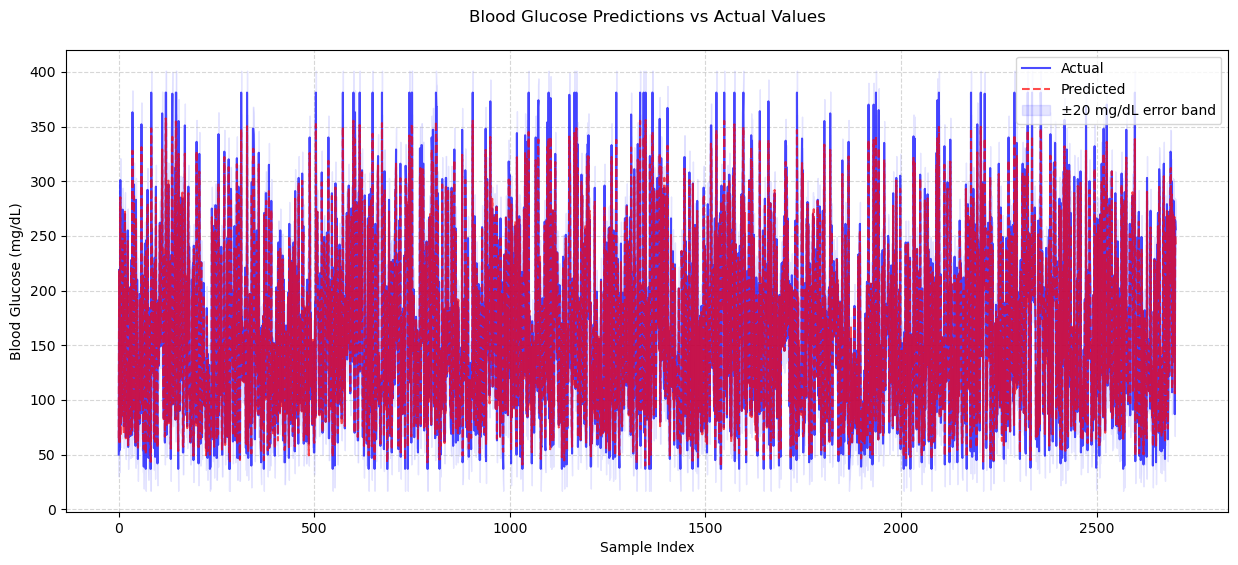

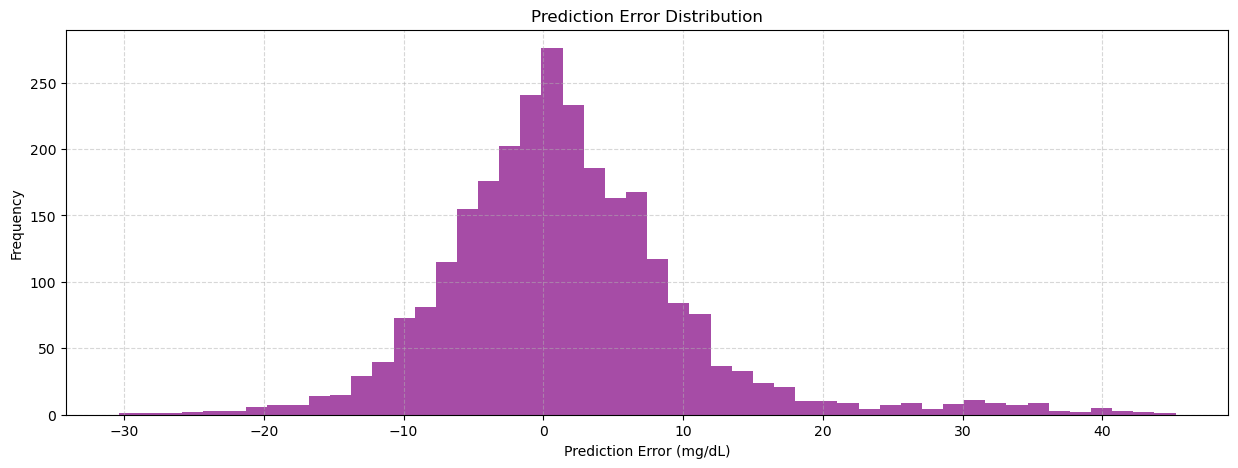

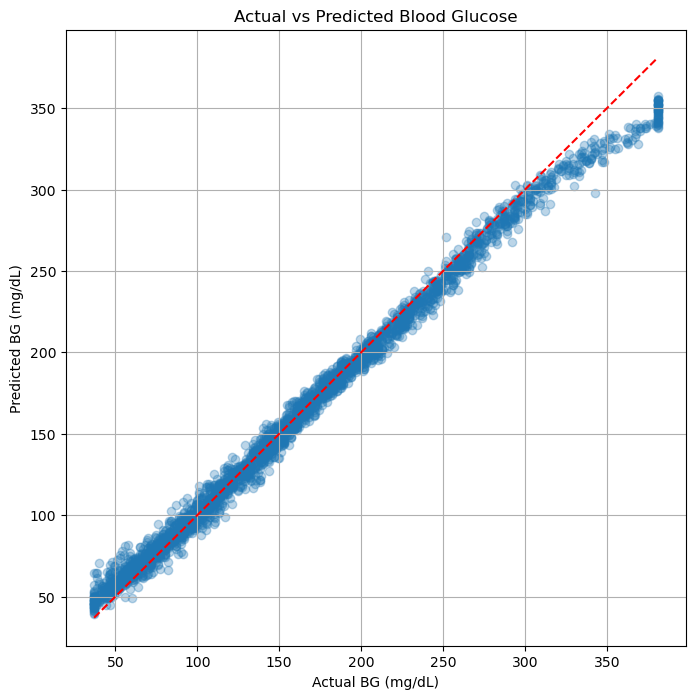

In [9]:
### 7. Main Execution Pipeline

def main():
    DATA_DIR = "./DiabetesDataset"  # Directory path
    
    try:
        print("=== Loading Data ===")
        files = load_data_files(DATA_DIR)
        df = process_raw_data(files)
        
        print("\n=== Creating Features ===")
        X, y = create_enhanced_features(df)
        
        # Ensure proper array formats
        X = np.array(X) if not isinstance(X, np.ndarray) else X
        y = np.array(y) if not isinstance(y, np.ndarray) else y
        
        print("\n=== Preprocessing Data ===")
        X_scaled, y_scaled, scaler_X, scaler_y = preprocess_data(X, y)
        
        # Verify shapes before reshaping
        print(f"X_scaled shape before reshape: {X_scaled.shape}")
        print(f"y_scaled shape: {y_scaled.shape}")
        
        # Proper reshaping for LSTM [samples, timesteps, features]
        if len(X_scaled.shape) == 2:
            n_features = X_scaled.shape[1]
            X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, n_features))
        
        print(f"X_scaled shape after reshape: {X_scaled.shape}")
        
        # Temporal train-test split
        test_size = int(0.2 * len(X_scaled))
        X_train, X_test = X_scaled[:-test_size], X_scaled[-test_size:]
        y_train, y_test = y_scaled[:-test_size], y_scaled[-test_size:]
        
        print("\n=== Building Model ===")
        model = build_advanced_model((X_train.shape[1], X_train.shape[2]))
        model.summary()
        
        print("\n=== Training Model ===")
        history = train_model(model, X_train, y_train, X_test, y_test)
        
        print("\n=== Evaluating Model ===")
        evaluate_results(model, X_test, y_test, scaler_y)
        
    except Exception as e:
        print(f"\nError in main execution: {str(e)}")
        print("Shapes at time of error:")
        if 'X_scaled' in locals():
            print(f"X_scaled shape: {X_scaled.shape}")
        if 'y_scaled' in locals():
            print(f"y_scaled shape: {y_scaled.shape}")

if __name__ == "__main__":
    main()